# Flow and transport problem - SPE10

In [1]:
import numpy as np
import porepy as pp
import scipy.sparse as sps
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os
import sys
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from tqdm import tqdm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
torch.manual_seed(1)

main_folder = os.getcwd()
spe10_folder = main_folder + "/PoreWorld/spe10"
sys.path.insert(1, spe10_folder)

from functions_cp3 import *
from spe10 import Spe10

/home/dave/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


In [2]:
def plot_perm(sd, perm_dict, position_concentration, position_well):
    """
    Plots the permeability matrix and the positions of concentration and well.

    Parameters:
    sd (float): Standard deviation value.
    perm_dict (dict): Dictionary containing the permeability values.
    position_concentration (tuple): Tuple containing the position of concentration.
    position_well (tuple): Tuple containing the position of the well.

    Returns:
    None
    """

    kxx = perm_dict["kxx"]
    perm_matrix = np.array(kxx).reshape(220,60)
    matrix = np.log10(perm_matrix)
    
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    x_concentration = np.floor(position_concentration[0] / 6.096)
    y_concentration = np.floor(position_concentration[1] / 3.0479999999999996)
    x_position_well = np.floor(position_well[0] / 6.096)
    y_position_well = np.floor(position_well[1] / 3.0479999999999996)
    plt.scatter(x_concentration, y_concentration, color='red', marker='x', s=100, label='concentration')
    plt.scatter(x_position_well, y_position_well, color='yellow', marker='x', s=100, label='well')
    plt.title('Permeability Matrix')
    plt.legend()
    plt.show()

In [3]:
def plot_perm_complete(sd, perm_dict, name_layer=False):
    """
    Plots the permeability matrix and a histogram of the permeability values.

    Parameters:
    - sd: The standard deviation.
    - perm_dict: A dictionary containing the permeability values.
    - name_layer: A boolean indicating whether to include the layer name in the plot title.

    Returns:
    None
    """

    kxx = perm_dict["kxx"]
    perm_matrix = np.array(kxx).reshape(220,60)
    matrix = np.log10(perm_matrix)
    
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    if name_layer:
        plt.title(f'Permeability Layer: {name_layer}')
    else:
        plt.title('Permeability Matrix')
    plt.subplot(1, 2, 2)
    kxx_log = np.log10(np.array(perm_dict["kxx"]).flatten())
    plt.hist(kxx_log, bins=40, color='blue', edgecolor='black')
    plt.show()

In [4]:
def solve_darcy(selected_layers, pos_well):
    """
    Solves the Darcy flow problem in a porous medium.

    Parameters:
    - selected_layers (list): List of selected layers in the porous medium.
    - pos_well (list): Position of the well in the porous medium.

    Returns:
    - sd (object): The Spe10 object representing the porous medium.
    - perm_dict (dict): Dictionary containing the permeability values of the porous medium.
    - q (array): Array of flux values at each cell in the porous medium.
    - b_faces (array): Array of boundary faces in the porous medium.
    - vect (array): Array representing the well location in the porous medium.
    - M (object): Sparse matrix representing the cell volumes in the porous medium.
    - U (object): Sparse matrix representing the discretized Darcy flow problem.
    - b_upwind (array): Array representing the right-hand side of the Darcy flow problem.

    """
    spe10 = Spe10(selected_layers)
    sd = spe10.sd
    perm_folder = spe10_folder + "/perm/"
    spe10.read_perm(perm_folder)
    perm_dict = spe10.perm_as_dict()

    perm = pp.SecondOrderTensor(kxx=perm_dict["kxx"], kyy=perm_dict["kyy"], kzz=perm_dict["kzz"])      
    injection_rate = 1
    b_faces = sd.tags["domain_boundary_faces"].nonzero()[0]
    b_face_centers = sd.face_centers[:, b_faces]
    labels = np.array(["neu"] * b_faces.size)
    bc_val = np.zeros(sd.num_faces)
    bc = pp.BoundaryCondition(sd, b_faces, labels)
    parameters = {"second_order_tensor": perm, "bc": bc, "bc_values": bc_val}

    flow_key = "flow"
    flow_data = pp.initialize_default_data(sd, {}, flow_key, parameters)

    mpfa = pp.Mpfa(flow_key)
    mpfa.discretize(sd, flow_data)
    A, b = mpfa.assemble_matrix_rhs(sd, flow_data)
    b_wells = np.zeros_like(b)
    index_iwells = [
        0,
        spe10.full_shape[0] - 1,
        spe10.full_shape[0] * spe10.full_shape[1] - spe10.full_shape[0],
        spe10.full_shape[0] * spe10.full_shape[1] - 1,
        ]
    b_wells[index_iwells] = injection_rate
    ij_well = np.floor( (np.asarray(pos_well) / spe10.spacing[:-1])).astype(int)
    index_pwell = spe10.full_shape[0] * ij_well[1] + ij_well[0]
    vect = np.zeros((sd.num_cells, 1))
    vect[index_pwell] = 1
    A = sps.bmat([[A, vect], [vect.T, None]], format="csc")
    b = np.append(b + b_wells, 0)
    cell_p = sps.linalg.spsolve(A, b)[:-1] # 13200 array
    mat_discr = flow_data[pp.DISCRETIZATION_MATRICES][flow_key]
    q = mat_discr["flux"] @ cell_p + mat_discr["bound_flux"] @ bc_val

    mvem = pp.MVEM(flow_key)                                                                                      
    mvem.discretize(sd, flow_data)                                                                                      
    cell_q = mvem.project_flux(sd, q, flow_data) # (3, 13200) matrix
    save = pp.Exporter(sd, "sol_p", folder_name="transport")
    data_to_export = [("kxx", np.log10(perm_dict["kxx"])), 
                    ("kyy", np.log10(perm_dict["kyy"])), 
                    ("kzz", np.log10(perm_dict["kzz"])),
                    ("cell_p", cell_p),
                    ("cell_q", cell_q)]
    save.write_vtu(data_to_export)

    transport_key = "transport"
    delta_t = 500
    num_steps = 200
    labels = np.array(["neu"] * b_faces.size)
    bc_val = np.zeros(sd.num_faces)
    bc = pp.BoundaryCondition(sd, b_faces, labels)
    parameters = {"darcy_flux": q, "bc": bc, "bc_values": bc_val}
    transport_data = pp.initialize_default_data(sd, {}, transport_key, parameters)

    upwind = pp.Upwind(transport_key)  #the problem is linear, upwind flux is fine (a bit diffusive)
    upwind.discretize(sd, transport_data)
    U, b_upwind = upwind.assemble_matrix_rhs(sd, transport_data)
    M = sps.csr_matrix(np.diag(sd.cell_volumes), shape=np.shape(U))

    return sd, perm_dict, q, b_faces, vect, M, U, b_upwind

In [5]:
def compute_outflow(initial_conc_pos, sd, perm_dict, q, b_faces, vect, M, U, b_upwind, pos_well, plots=False):
    """
    Computes the outflow from a well in a porous media simulation.

    Parameters:
    - initial_conc_pos (tuple): The initial concentration position as a tuple of (x, y) coordinates.
    - sd: The simulation domain.
    - perm_dict: A dictionary containing the permeability values.
    - q: The flow rate.
    - b_faces: The boundary faces.
    - vect: The vector.
    - M: The mass matrix.
    - U: The upwind matrix.
    - b_upwind: The upwind boundary condition.
    - pos_well: The position of the well.
    - plots (bool): Whether to plot the results or not. Default is False.

    Returns:
    - outflow (list): A list of outflow values at each time step.
    """
    
    kxx = perm_dict["kxx"]
    L = 50
    delta_t = 500
    num_steps = 200
    ini_cond = np.logical_and((np.abs(sd.cell_centers[0,:]-initial_conc_pos[0])<L/2),(np.abs(sd.cell_centers[1,:]-initial_conc_pos[1])<L/2))
    c = np.zeros(sd.num_cells)
    c[ini_cond] = 1

    initial_mass = np.sum(c*sd.cell_volumes)
    save = pp.Exporter(sd, "sol_c", folder_name="transport")
    save.write_vtu([("conc", c)], time_step=0)
    S = M + delta_t * U
    S = sps.bmat([[S, vect], [vect.T, None]], format="csc")

    outflow = []
    lu = sps.linalg.splu(S.tocsc())

    for i in np.arange(num_steps):
        b = M @ c + delta_t * b_upwind
        b=np.append(b,0)
        sol = lu.solve(b)
        c = sol[:-1]
        ll = sol[-1]
        save.write_vtu([("conc", c)], time_step=(i+1)*delta_t)
        outflow.append(ll)
    
    total_outflow = np.sum(outflow)
    final_internal_mass = np.sum(c*sd.cell_volumes)

    if plots==True:
        x = initial_conc_pos[0]
        y = initial_conc_pos[1]

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.plot(np.arange(num_steps), outflow)
        plt.title(f'Outflow Data -> {total_outflow/initial_mass*100:.2f}%')
        plt.xlabel(f'Time -> {np.argmax(outflow):.2f}')
        plt.ylabel(f'Outflow -> {np.max(outflow):.2f}')
        
        plt.subplot(1, 3, 2)
        plot_perm(sd, perm_dict, [x, y], pos_well)

        plt.subplot(1, 3, 3)
        kxx_log = np.log10(np.array(perm_dict["kxx"]).flatten())
        plt.hist(kxx_log, bins=40, color='blue', edgecolor='black')
        idx = int((x/6.096)*(y/3.0479999999999996))
        line = np.log10(kxx[13200 - idx])
        plt.axvline(x=line, color='red', linestyle='--', linewidth=2)
        plt.title('Histogram of log10(kxx) Values')
        plt.xlabel('log10(kxx) Value')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

    return outflow

In [6]:
spe10 = Spe10(51)
sd = spe10.sd
perm_folder = spe10_folder + "/perm/"
spe10.read_perm(perm_folder)
perm_dict = spe10.perm_as_dict()
kxx = perm_dict["kxx"]

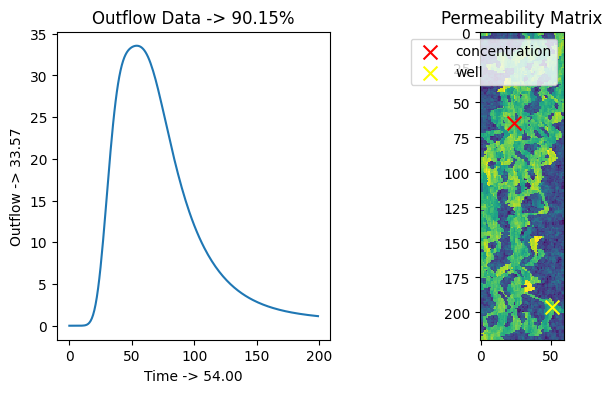

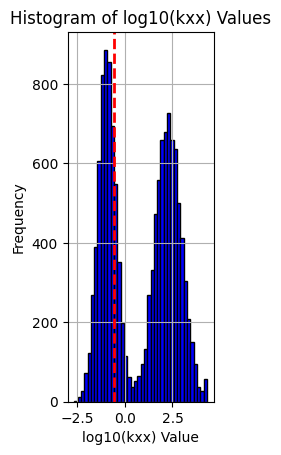

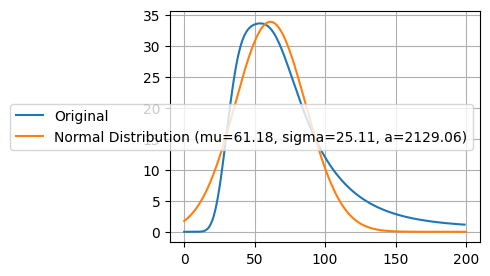

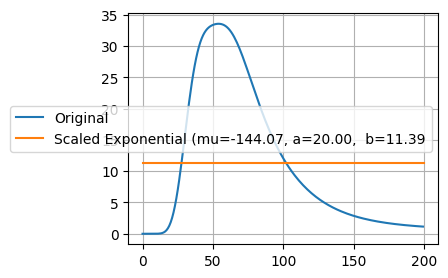

In [46]:
# test on 1 layer
selected_layer = 51
with open(f'data/l{selected_layer}.pickle', 'rb') as f: data = pickle.load(f)
pos_well = data[1][np.argmin(data[2])] # pos_Well = 313, 598

#list_initial_conc_pos = [[48,600], [292,495], [350,450], [50,25]] # prof's starting points
#list_initial_conc_pos = [(246.38800000000003, 548.212)]                                   # max time 4.0 sec -> N NOT OK, EXP NEITHER, mu < 0, a huge
# list_initial_conc_pos = [[np.floor(55.0*6.096), np.floor(49.0*3.0479999999999996)]]
#list_initial_conc_pos = [[300,550]]                                                     # max time 178.0 sec -> patologico ma N OK
#list_initial_conc_pos = [[350,550]]                                                     # max time 199.0 sec -> patologico ma N OK, 3 params range accettabile
# list_initial_conc_pos = [[np.floor(40.0*6.096), np.floor(179.0*3.0479999999999996)]]    # max time 4.0 sec -> patologico, a huge
#list_initial_conc_pos = [[np.floor(40.0*6.096), np.floor(169.0*3.0479999999999996)]]    # double spike -> patological
#list_initial_conc_pos = [[300,600]]                                                     # exponential, time 0.0 sec -> patological, mu < 0 and a huge
#list_initial_conc_pos = [(326, 638.212)] # outflow 100%, N OK but a huge
# list_initial_conc_pos = [(316, 638.212)] # outflow 100%, N OK but mu < 0, a huge
# list_initial_conc_pos = [(313, 560.212)]
#list_initial_conc_pos = [(319, 579.212)] # exponential case
#list_initial_conc_pos = [(150, 450.212)]
list_initial_conc_pos = [[150,200]]                                                     # max time 199.0 sec -> patologico ma N OK, 3 params range accettabile


sd, perm_dict, q, b_faces, vect, M, U, b_upwind = solve_darcy(selected_layer, pos_well)
for elem in list_initial_conc_pos:
    out = compute_outflow(elem, sd, perm_dict, q, b_faces, vect, M, U, b_upwind, pos_well, plots=True)
    estimate_gaussian_parameters(out, plots=True)
    estimate_exponential_parameters(out, plots=True)

(200, 9)


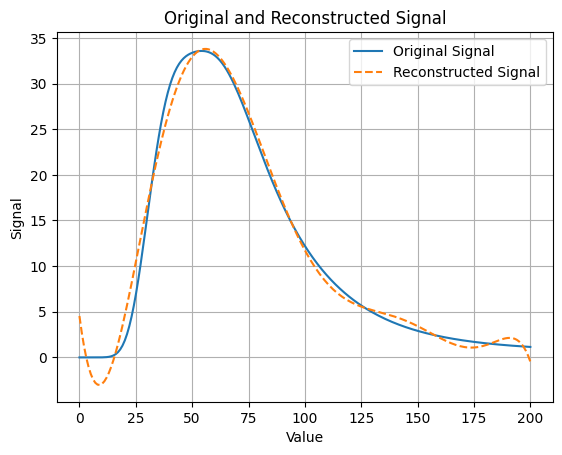

Mean Square Error: 1.5193688975565542
Coefficients shape: (9,)
(200,)


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hermitenorm
out = np.array(out)


# Generate the grid
N = 200
x_min, x_max = 0, 200
x = np.linspace(x_min, x_max, N)

# Define the Hermite polynomial order
N_hermite = 9

# Define the Hermite polynomials
Hermite = [hermitenorm(n) for n in range(N_hermite)]

# Compute Hermite basis functions
basis_functions = np.zeros((N, N_hermite))
for i in range(N_hermite):
    basis_functions[:, i] = Hermite[i]((x - x_min) / (x_max - x_min))

print(np.shape(basis_functions))

# Example signal - Gamma Distribution PDF
c = out

# Compute coefficients using least squares regression
coeff, _, _, _ = np.linalg.lstsq(basis_functions, c, rcond=None)

# Reconstruct the signal using the coefficients
rec = np.dot(basis_functions, coeff)

# Plot the reconstructed signal
plt.plot(x, c, label='Original Signal')
plt.plot(x, rec, '--', label='Reconstructed Signal')
plt.xlabel('Value')
plt.ylabel('Signal')
plt.title('Original and Reconstructed Signal')
plt.legend()
plt.grid(True)
plt.show()

# Calculate mean square error
mse = np.mean((rec - c)**2)

# Print mean square error
print("Mean Square Error:", mse)
print("Coefficients shape:", np.shape(coeff))

print(np.shape(c))

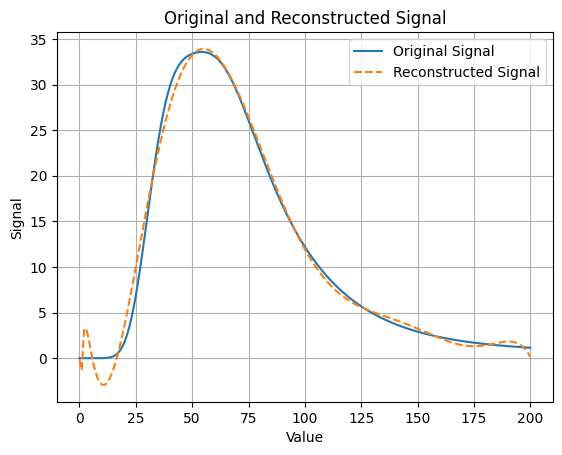

Mean Square Error: 1.0489356927318232
Coefficients shape: (12,)


In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hermitenorm

# Generate the grid
N = 200
x_min, x_max = 0, 200
x = np.linspace(x_min, x_max, N)

# Define the Hermite polynomial order
N_hermite = 9

# Define the Hermite polynomials
Hermite = [hermitenorm(n) for n in range(N_hermite)]

# Compute Hermite basis functions
basis_functions = np.zeros((N, N_hermite))
for i in range(N_hermite):
    basis_functions[:, i] = Hermite[i]((x - x_min) / (x_max - x_min))



# Additional basis function
#additional_basis = 1 / (x + 1.5)
additional_basis_exp = np.exp(-x)

additional_basis_log = np.exp(-(np.log(x+0.13)+0.5)**2)

#basis_functions = np.column_stack((basis_functions, additional_basis))
basis_functions = np.column_stack((basis_functions, additional_basis_exp))
basis_functions = np.column_stack((basis_functions, additional_basis_log))
basis_functions = np.column_stack((basis_functions, additional_basis_exp_pos))



# Example signal - Gamma Distribution PDF
# Assuming 'out' is defined somewhere in your code
out = np.array(out)
c = out

# Compute coefficients using least squares regression
coeff, _, _, _ = np.linalg.lstsq(basis_functions, c, rcond=None)

# Reconstruct the signal using the coefficients
rec = np.dot(basis_functions, coeff)

# Plot the reconstructed signal
plt.plot(x, c, label='Original Signal')
plt.plot(x, rec, '--', label='Reconstructed Signal')
plt.xlabel('Value')
plt.ylabel('Signal')
plt.title('Original and Reconstructed Signal')
plt.legend()
plt.grid(True)
plt.show()

# Calculate mean square error
mse = np.mean((rec - c)**2)

# Print mean square error
print("Mean Square Error:", mse)
print("Coefficients shape:", np.shape(coeff))


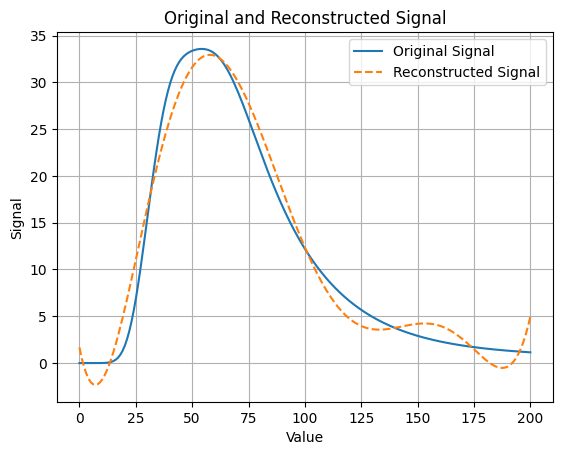

Mean Square Error: 3.2341051053453564
Coefficients shape: (10,)


In [102]:
""" import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hermitenorm

# Generate the grid
N = 200
x_min, x_max = 0, 200
x = np.linspace(x_min, x_max, N)

# Define the Hermite polynomial order
N_hermite = 10

# Define the Hermite polynomials
Hermite = [hermitenorm(n) for n in range(N_hermite)]

# Compute Hermite basis functions
basis_functions = np.zeros((N, N_hermite))
for i in range(N_hermite):
    basis_functions[:, i] = Hermite[i]((x - x_min) / (x_max - x_min))

# Example signal - Replace with your data

# Define regularization parameter (adjust as needed)
alpha = 0.00000001

# Compute the Gram matrix
gram_matrix = np.dot(basis_functions.T, basis_functions)

# Regularization term
regularization_term = alpha * np.eye(N_hermite)

# Compute coefficients using regularized least squares regression
coeff = np.linalg.inv(gram_matrix + regularization_term).dot(basis_functions.T.dot(out))

# Reconstruct the signal using the coefficients
rec = np.dot(basis_functions, coeff)

# Plot the reconstructed signal
plt.plot(x, out, label='Original Signal')
plt.plot(x, rec, '--', label='Reconstructed Signal')
plt.xlabel('Value')
plt.ylabel('Signal')
plt.title('Original and Reconstructed Signal')
plt.legend()
plt.grid(True)
plt.show()

# Calculate mean square error
mse = np.mean((rec - out)**2)

# Print mean square error
print("Mean Square Error:", mse)
print("Coefficients shape:", np.shape(coeff)) """
 

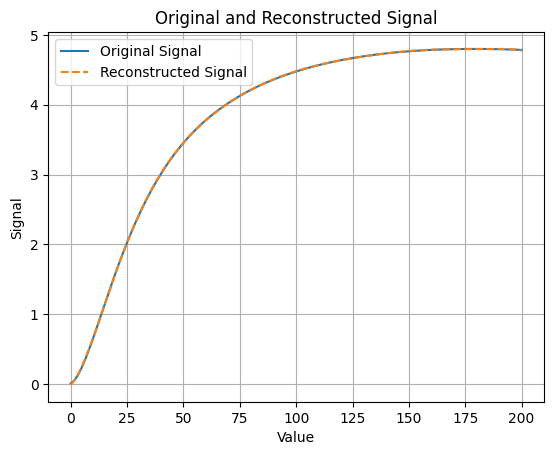

Mean Square Error: 1.806569736530652e-05


In [84]:
max_original = np.max(out)
max_reconstructed = np.max(rec)
scaling_factor = max_original / max_reconstructed
rec_scaled = rec * scaling_factor

# Plot the reconstructed signal
plt.plot(x, out, label='Original Signal')
plt.plot(x, rec_scaled, '--', label='Reconstructed Signal')
plt.xlabel('Value')
plt.ylabel('Signal')
plt.title('Original and Reconstructed Signal')
plt.legend()
plt.grid(True)
plt.show()

# Calculate mean square error
mse = np.mean((rec_scaled - out)**2)
print("Mean Square Error:", mse)

In [6]:
def generate_neural_network_training_data(sd, kxx, perm_dict, q, b_faces, vect, M, U, b_upwind, initial_conc_pos, pos_well, func="Normal", outputs=False):
    """
    Generate neural network training data based on the given parameters.

    Parameters:
    - kxx (list): List of kxx values.
    - initial_conc_pos (tuple): Tuple containing the initial concentration position (x, y).
    - pos_well (tuple): Tuple containing the position of the well (x, y).
    - outputs (bool): Flag indicating whether to display additional outputs.

    Returns:
    - neural_network_inputs (list): List of neural network input values.
    - neural_network_outputs (list): List of neural network output values.
    """

    x_concentration, y_concentration = np.floor(initial_conc_pos[0] / 6.096), np.floor(initial_conc_pos[1] / 3.0479999999999996)
    x_position_well, y_position_well = np.floor(pos_well[0] / 6.096), np.floor(pos_well[1] / 3.0479999999999996)
    
    neural_network_inputs, neural_network_outputs = [], []
    neural_network_inputs.append(x_concentration)
    neural_network_inputs.append(y_concentration)
    
    x_center, y_center = x_concentration, y_concentration
    radius_big = radius_small = 7
    num_points = 4
    angles = np.linspace(0, 2*np.pi, num_points, endpoint=False)
    x_points, y_points = np.zeros(num_points), np.zeros(num_points)
    angles = np.linspace(0, 2*np.pi, num_points, endpoint=False)
    for i, angle in enumerate(angles):
        if i % 2 == 0:
            x_points[i] = x_center + radius_small * np.cos(angle)
            y_points[i] = y_center + radius_small * np.sin(angle)
        else:
            x_points[i] = x_center + radius_big * np.cos(angle)
            y_points[i] = y_center + radius_big * np.sin(angle)
        
    for x, y in zip(x_points, y_points):
        if 0 < y <= 220 and 0 < x <= 60:
            idx = int(x * y)
            kxx_value = kxx[13200 - idx - 1]
            neural_network_inputs.append(kxx_value)
        elif (x < 0.0 or x > 60) and y > 0:
            idx = int(y)
            kxx_value = kxx[13200 - idx - 1]
            neural_network_inputs.append(kxx_value)
        elif (y < 0.0 or y > 220) and x > 0:
            idx = int(x)
            kxx_value = kxx[13200 - idx - 1]
            neural_network_inputs.append(kxx_value)
        else:
            idx = int(x_center * x_center)
            kxx_value = kxx[13200 - idx - 1]
            neural_network_inputs.append(kxx_value)

    out = compute_outflow(initial_conc_pos, sd, perm_dict, q, b_faces, vect, M, U, b_upwind, pos_well, plots=False)

    if func == "Normal":
        mu, sigma, a = estimate_gaussian_parameters(out)
        neural_network_outputs.append(mu)
        neural_network_outputs.append(sigma)
        neural_network_outputs.append(a)

    elif func == "Exponential":
        mu, a, b = estimate_exponential_parameters(out)
        neural_network_outputs.append(mu)
        neural_network_outputs.append(a)
        neural_network_outputs.append(b)

    if outputs:
        perm_matrix = np.array(kxx).reshape(220,60)
        matrix = np.log10(perm_matrix)
        print(f"x coordinate: {x_concentration}")
        print(f"y coordinate: {y_concentration}")
        plt.imshow(matrix, cmap='viridis', interpolation='nearest')
        plt.scatter(x_concentration, y_concentration, color='orange', marker='x', s=100, label='concentration')
        plt.scatter(x_position_well, y_position_well, color='yellow', marker='x', s=100, label='well')
        theta = np.linspace(0, 2*np.pi, 100)
        x_circle = x_concentration + radius_big * np.cos(theta)
        y_circle = y_concentration + radius_big * np.sin(theta)
        plt.plot(x_circle, y_circle, color='orange', linestyle='--', label='circle')
        for neighbor in neighbors:
            plt.scatter(neighbor[0], neighbor[1], color='red', marker='x')

    return neural_network_inputs, neural_network_outputs

In [7]:
def estimate_exponential_parameters(out, plots=False):
    y = out
    x = np.linspace(0, 200, 200)
    initial_guess = [50, 20, 5]

    def scaled_exponential(x, mu, a, b):
        return a * np.exp(-(x - mu)) + b

    def objective(params):
        mu, a, b = params
        y_hat = scaled_exponential(x, mu, a, b)
        return np.sum((y - y_hat)**2)

    result = minimize(objective, initial_guess, method='Powell')
    mu_optimal, a_optimal, b_optimal = result.x
    y_hat_optimal = scaled_exponential(x, mu_optimal, a_optimal, b_optimal)

    if plots:
        plt.figure(figsize=(4, 3))
        plt.plot(y, label="Original")
        plt.plot(x, y_hat_optimal, label=f'Scaled Exponential (mu={mu_optimal:.2f}, a={a_optimal:.2f},  b={b_optimal:.2f}')
        plt.legend()
        plt.grid(True)
        plt.show()

    return mu_optimal, a_optimal, b_optimal


In [8]:
def estimate_gaussian_parameters(out, plots=False):
    
    y = out
    x = np.linspace(0, 200, 200)
    initial_guess = [50, 20, 200]

    def normal_distribution(x, mu, sigma, a):
        return a*norm.pdf(x, mu, sigma)

    def objective(params):
        mu, sigma, a = params
        y_hat = normal_distribution(x, mu, sigma, a)
        return np.sum((y - y_hat)**2)
    
    if np.max(y) < 1:
        return 0, 0, 0
    
    result = minimize(objective, initial_guess, method='Nelder-Mead')
    mu_optimal, sigma_optimal, a_optimal = result.x
    y_hat_optimal = normal_distribution(x, mu_optimal, sigma_optimal, a_optimal)

    if plots:
        plt.figure(figsize=(4, 3))
        plt.plot(y, label="Original")
        plt.plot(x, y_hat_optimal, label=f'Normal Distribution (mu={mu_optimal:.2f}, sigma={sigma_optimal:.2f}, a={a_optimal:.2f})')
        plt.legend()
        plt.grid(True)
        plt.show()

    return mu_optimal, sigma_optimal, a_optimal

In [15]:
# # test on 1 layer
# out = compute_outflow([48,600], sd, perm_dict, q, b_faces, vect, M, U, b_upwind, pos_well, plots=False)
# mu, sigma, a = estimate_gaussian_parameters(out, plots=True)

## Generate Data

In [9]:
# check list of coordinates
layer = 42
with open(f'PoreWorld/data/layer_{layer}_list_coordinates.pickle', 'rb') as f: 
    list_initial_conc_pos = pickle.load(f)
print(len(list_initial_conc_pos))

def count_unique_pairs(list_initial_conc_pos):
    unique_pairs = set()
    for pair in list_initial_conc_pos:
        unique_pairs.add(tuple(pair))
    return unique_pairs

unique_pairs_set = count_unique_pairs(list_initial_conc_pos)
unique_pairs = list(unique_pairs_set)
print(len(unique_pairs))

2000
2000


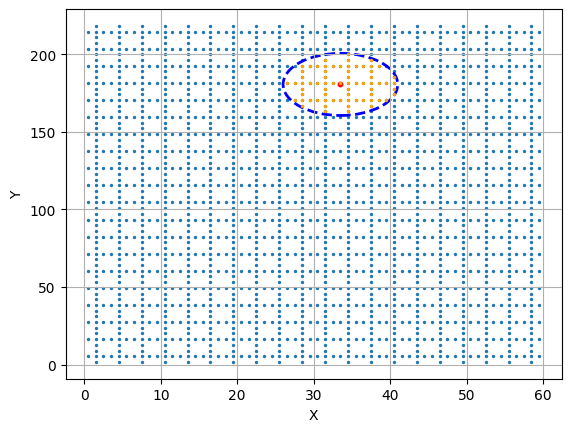

In [10]:
from matplotlib.patches import Ellipse
list_initial_conc_pos = unique_pairs
x_coords = [coord[0]/6.096 for coord in list_initial_conc_pos]
y_coords = [coord[1]/3.048 for coord in list_initial_conc_pos]
with open(f'PoreWorld/data/l{layer}.pickle', 'rb') as f: well_data = pickle.load(f)
pos_well = well_data[1][np.argmin(well_data[2])]

plt.scatter(x_coords, y_coords, s=2)
plt.scatter(pos_well[0]/6.096, pos_well[1]/3.048, color='red', s=10)
center = (pos_well[0]/6.096, pos_well[1]/3.048)
width = 15  # Major axis length
height = 40  # Minor axis length
ellipse = Ellipse(xy=center, width=width, height=height, edgecolor='blue', facecolor='none', linestyle='--', linewidth=2)
plt.gca().add_patch(ellipse)

coords_inside_ellipse = []
a = height/2
b = width/2
for x, y in zip(x_coords, y_coords):
    
    if (((x - pos_well[0]/6.096)**2)*(a**2) + ((y - pos_well[1]/3.048)**2)*(b**2)) <= (a**2 * b**2):
        coords_inside_ellipse.append((x, y))

coords_inside_ellipse = np.array(coords_inside_ellipse)
plt.scatter(coords_inside_ellipse[:, 0], coords_inside_ellipse[:, 1], color='orange', label='Inside Ellipse', s=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

In [10]:
def compute_training_data(layer):
    spe10 = Spe10(layer)
    sd = spe10.sd
    perm_folder = spe10_folder + "/perm/"
    spe10.read_perm(perm_folder)
    perm_dict = spe10.perm_as_dict()
    kxx = perm_dict["kxx"]

    with open(f'PoreWorld/data/l{layer}.pickle', 'rb') as f: data = pickle.load(f)
    pos_well = data[1][np.argmin(data[2])]

    with open(f'PoreWorld/data/layer_{layer}_list_coordinates.pickle', 'rb') as f: list_initial_conc_pos = pickle.load(f)

    _, _, q, b_faces, vect, M, U, b_upwind = solve_darcy(layer, pos_well)

    list_neural_network_inputs, list_neural_network_outputs = [], []

    idx = 0
    for elem in list_initial_conc_pos:
        neural_network_inputs, neural_network_outputs = generate_neural_network_training_data(sd, kxx, perm_dict, q, b_faces, vect, M, U, b_upwind, elem, pos_well)
        list_neural_network_inputs.append(neural_network_inputs)
        list_neural_network_outputs.append(neural_network_outputs)
        if idx%100 == 0:
            print(f"Progress: {idx/len(list_initial_conc_pos)*100:.2f}%")
        idx += 1

    pickle_filename_input = f"layer_{layer}_list_neural_network_inputs"
    pickle_filename_output = f"layer_{layer}_list_neural_network_outputs"
    with open(f"PoreWorld/data/{pickle_filename_input}.pickle", 'wb') as f:
        pickle.dump(list_neural_network_inputs, f)
        print(f"Result saved to '{pickle_filename_input}'")
    with open(f"PoreWorld/data/{pickle_filename_output}.pickle", 'wb') as f:
        pickle.dump(list_neural_network_outputs, f)
        print(f"Result saved to '{pickle_filename_output}'")

In [11]:
# selected_layers = [51, 71, 42, 20, 12, 2, 82]
selected_layers = [71]
for layer in selected_layers:
    compute_training_data(layer)

Progress: 0.00%
Progress: 5.00%
Progress: 10.00%
Progress: 15.00%
Progress: 20.00%
Progress: 25.00%
Progress: 30.00%
Progress: 35.00%
Progress: 40.00%
Progress: 45.00%
Progress: 50.00%
Progress: 55.00%
Progress: 60.00%
Progress: 65.00%
Progress: 70.00%
Progress: 75.00%
Progress: 80.00%
Progress: 85.00%
Progress: 90.00%
Progress: 95.00%
Result saved to 'layer_71_list_neural_network_inputs'
Result saved to 'layer_71_list_neural_network_outputs'


In [11]:
layer = 42
with open(f'PoreWorld/data/layer_{layer}_list_neural_network_inputs.pickle', 'rb') as f: 
    list_neural_network_inputs = pickle.load(f)

print(len(list_neural_network_inputs))
unique_pairs_set = count_unique_pairs(list_neural_network_inputs)
unique_pairs = list(unique_pairs_set)
print(len(unique_pairs))

2000
2000


## Train MLP

In [12]:
class MLP(nn.Module):
    
    def __init__(self):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(6, 32).float()
        self.relu1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(32, 16).float()
        self.relu2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(16, 8).float()
        self.relu3 = nn.LeakyReLU()
        self.fc4 = nn.Linear(8, 3).float()
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)

    def forward(self, x):
        
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        
        return x

50


<Figure size 640x480 with 0 Axes>

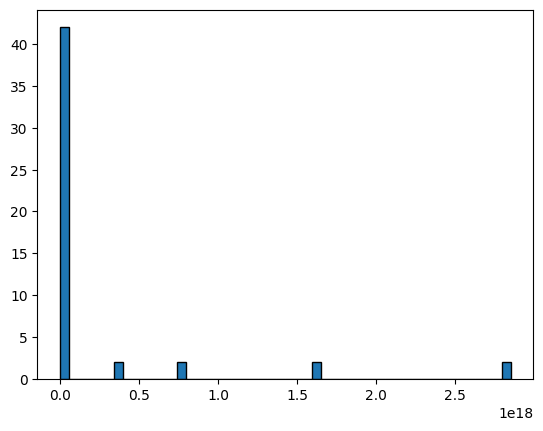

<Figure size 640x480 with 0 Axes>

In [39]:
# plot distribution of original inputs
with open(f'PoreWorld/data/layer_{layer}_list_neural_network_outputs.pickle', 'rb') as f: 
    list_neural_network_outputs = pickle.load(f)
with open(f'PoreWorld/data/layer_{layer}_list_neural_network_inputs.pickle', 'rb') as f: 
    list_neural_network_inputs = pickle.load(f)

list_of_as = []
count = 0
for i in range(len(list_neural_network_outputs)):
    if list_neural_network_outputs[i][2] > 3000: 
        count+=1
        list_of_as.append(list_neural_network_outputs[i][2])
        test = list_neural_network_outputs[i]
        # print(list_neural_network_outputs[i])
        # print(list_neural_network_inputs[i])
plt.figure()
plt.hist(list_of_as, bins=50, edgecolor='black')
print(count)
plt.figure()

In [13]:
selected_layers = [42]
# selected_layers = [51, 71, 42, 20, 12, 2, 82]

for layer in selected_layers:

    with open(f'PoreWorld/data/layer_{layer}_list_neural_network_inputs.pickle', 'rb') as f: list_neural_network_inputs_complete = pickle.load(f)
    with open(f'PoreWorld/data/layer_{layer}_list_neural_network_outputs.pickle', 'rb') as f: list_neural_network_outputs_complete = pickle.load(f)
    with open(f'PoreWorld/data/l{layer}.pickle', 'rb') as f: well_data = pickle.load(f)
    pos_well = well_data[1][np.argmin(well_data[2])]
    
    list_neural_network_inputs, list_neural_network_outputs = [], []
    list_of_exponentials_inputs, list_of_exponentials_outputs = [], []

    width = 10
    height = 35
    a = height/2
    b = width/2
    for i in range(len(list_neural_network_outputs_complete)):
        if list_neural_network_outputs_complete[i][2] > 3000 or list_neural_network_outputs_complete[i][0] < 0 or (((list_neural_network_inputs_complete[i][0] - pos_well[0]/6.096)**2)*(a**2) + (list_neural_network_inputs_complete[i][1] - pos_well[1]/3.048)**2)*(b**2) <= (a**2 * b**2):
                list_of_exponentials_inputs.append(list_neural_network_inputs_complete[i])
                list_of_exponentials_outputs.append(list_neural_network_outputs_complete[i])
        else:
            list_neural_network_inputs.append(list_neural_network_inputs_complete[i])
            list_neural_network_outputs.append(list_neural_network_outputs_complete[i])
    
    print(f"Number of inputs in original data: {len(list_neural_network_inputs_complete)}")
    print(f"Number of outputs in original data: {len(list_neural_network_outputs_complete)}")
    print(f"Number of inputs in transformed data: {len(list_neural_network_inputs)}")
    print(f"Number of outputs in transformed data: {len(list_neural_network_outputs)}")
    print(f"Number of exponential inputs: {len(list_of_exponentials_inputs)}")
    print(f"Number of exponential outputs: {len(list_of_exponentials_outputs)}")

    inputs_tensor = torch.tensor(list_neural_network_inputs)
    targets_tensor = torch.tensor(list_neural_network_outputs)

    ##### Substitute Exponential Params
    list_of_exponentials_inputs_transformed, list_of_exponentials_outputs_transformed = [], []
    spe10 = Spe10(layer)
    sd = spe10.sd
    perm_folder = spe10_folder + "/perm/"
    spe10.read_perm(perm_folder)
    perm_dict = spe10.perm_as_dict()
    kxx = perm_dict["kxx"]
    _, _, q, b_faces, vect, M, U, b_upwind = solve_darcy(layer, pos_well)
    for elem in list_of_exponentials_inputs:
        initial_conc_pos = [elem[0]*6.096, elem[1]*3.048]
        _, o = generate_neural_network_training_data(sd, kxx, perm_dict, q, b_faces, vect, M, U, b_upwind, initial_conc_pos, pos_well, func="Exponential")
        if o[0] > 0:
            list_of_exponentials_outputs_transformed.append(o)
            list_of_exponentials_inputs_transformed.append(elem)
        else:
            continue
    # with open(f'PoreWorld/models/layer_{layer}_list_Exp_neural_network_outputs.pickle', 'wb') as f: pickle.dump(scaler_inputs, f)
    # with open(f'PoreWorld/models/layer_{layer}_Norm_scaler_targets.pickle', 'wb') as f: pickle.dump(scaler_targets, f)
    ##### Substitute Exponential Params

    inputs_tensor_exponentials = torch.tensor(list_of_exponentials_inputs_transformed)
    targets_tensor_exponentials = torch.tensor(list_of_exponentials_outputs_transformed)

    scaler_inputs, scaler_targets = MinMaxScaler(), MinMaxScaler()
    inputs_normalized = scaler_inputs.fit_transform(inputs_tensor)
    targets_normalized = scaler_targets.fit_transform(targets_tensor)
    with open(f'PoreWorld/models/layer_{layer}_Norm_scaler_inputs.pickle', 'wb') as f: pickle.dump(scaler_inputs, f)
    with open(f'PoreWorld/models/layer_{layer}_Norm_scaler_targets.pickle', 'wb') as f: pickle.dump(scaler_targets, f)

    scaler_inputs_exponentials, scaler_targets_exponentials = MinMaxScaler(), MinMaxScaler()
    inputs_normalized_exponentials = scaler_inputs_exponentials.fit_transform(inputs_tensor_exponentials)
    targets_normalized_exponentials = scaler_targets_exponentials.fit_transform(targets_tensor_exponentials)
    with open(f'PoreWorld/models/layer_{layer}_Exp_scaler_inputs.pickle', 'wb') as f: pickle.dump(scaler_inputs_exponentials, f)
    with open(f'PoreWorld/models/layer_{layer}_Exp_scaler_targets.pickle', 'wb') as f: pickle.dump(scaler_targets_exponentials, f)

    inputs_normalized_tensor, targets_normalized_tensor = torch.tensor(inputs_normalized), torch.tensor(targets_normalized)
    inputs_tensor, targets_tensor = inputs_normalized_tensor.float(), targets_normalized_tensor.float()

    inputs_normalized_tensor_exponentials, targets_normalized_tensor_exponentials = torch.tensor(inputs_normalized_exponentials), torch.tensor(targets_normalized_exponentials)
    inputs_tensor_exponentials, targets_tensor_exponentials = inputs_normalized_tensor_exponentials.float(), targets_normalized_tensor_exponentials.float()

    print(f'Shape of norm tensor inputs: {inputs_tensor.shape}')
    print(f'Shape of norm tensor targets: {targets_tensor.shape}')
    print(f'Shape of exp tensor inputs: {inputs_tensor_exponentials.shape}')
    print(f'Shape of exp tensor targets: {targets_tensor_exponentials.shape}')

Number of inputs in original data: 2000
Number of outputs in original data: 2000
Number of inputs in transformed data: 1837
Number of outputs in transformed data: 1837
Number of exponential inputs: 163
Number of exponential outputs: 163


Shape of norm tensor inputs: torch.Size([1837, 6])
Shape of norm tensor targets: torch.Size([1837, 3])
Shape of exp tensor inputs: torch.Size([67, 6])
Shape of exp tensor targets: torch.Size([67, 3])


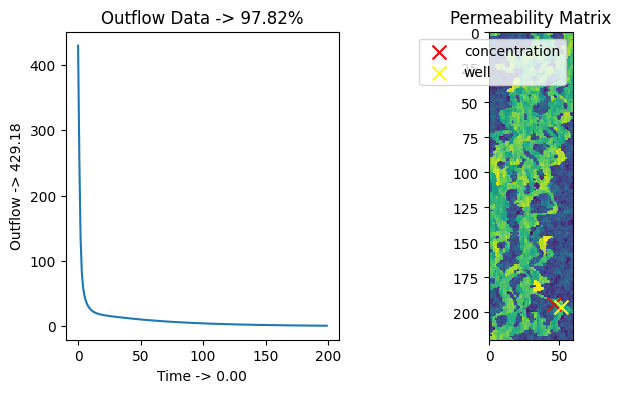

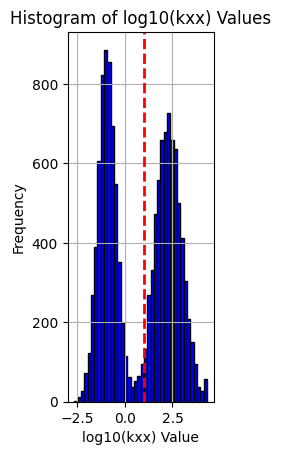

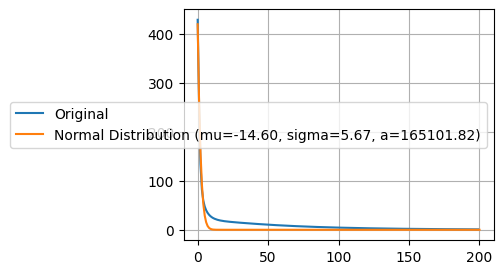

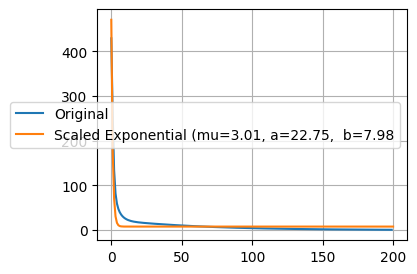

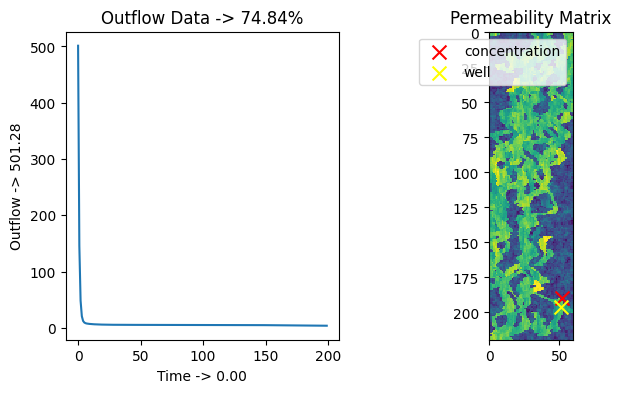

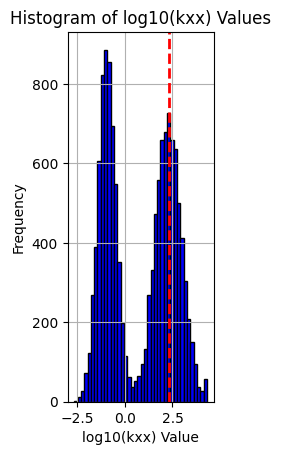

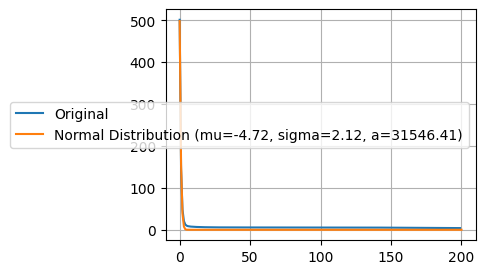

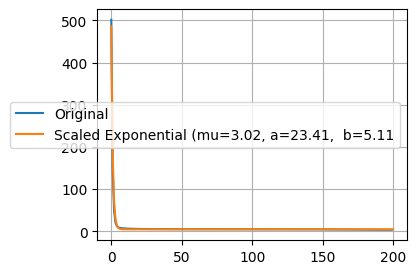

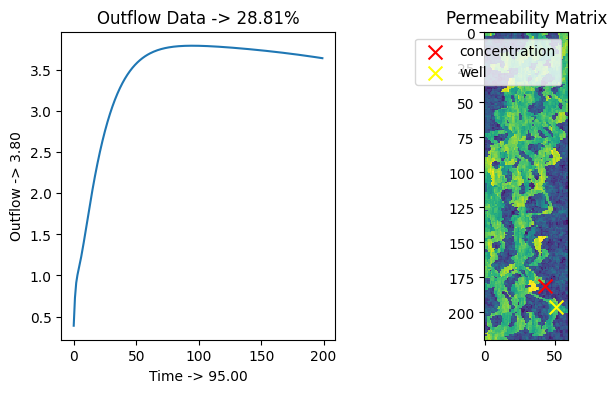

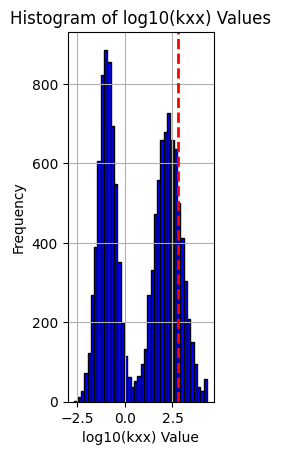

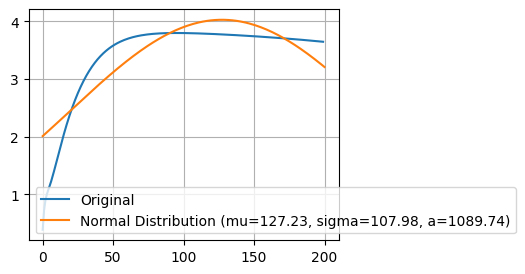

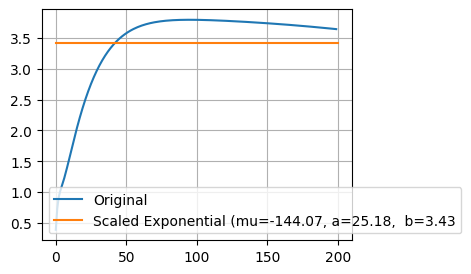

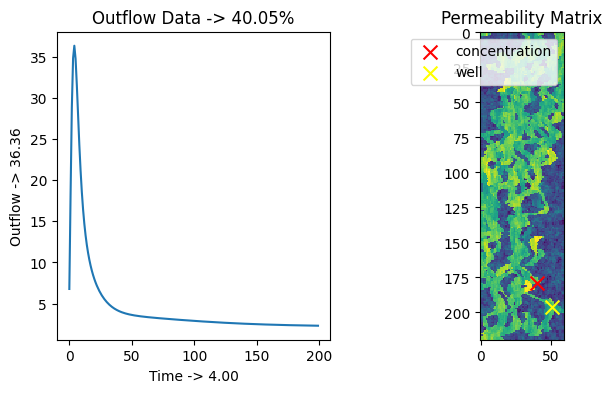

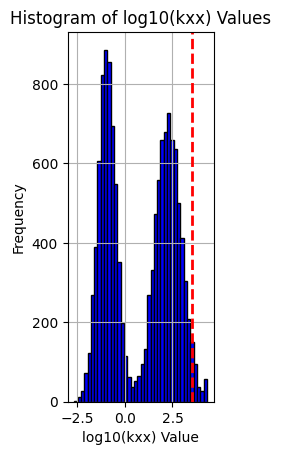

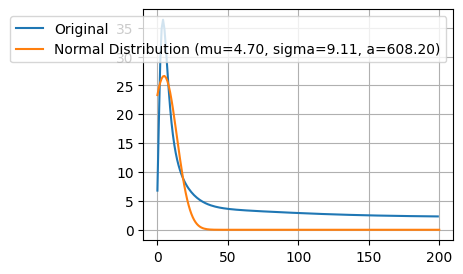

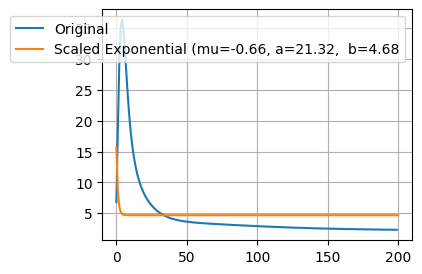

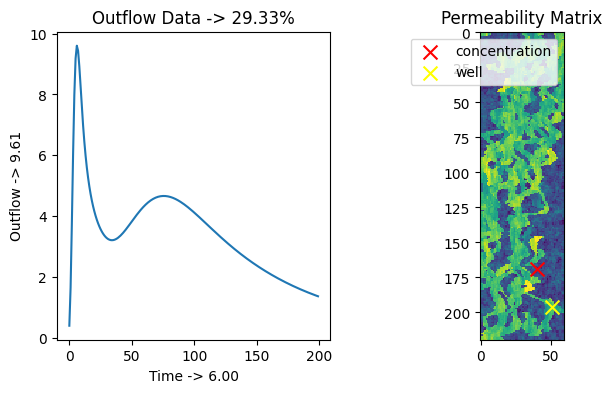

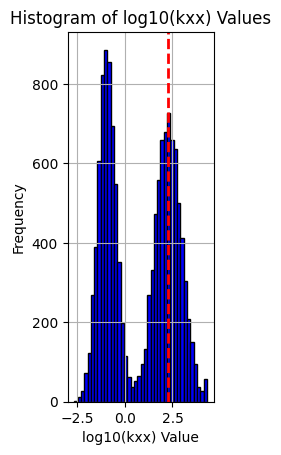

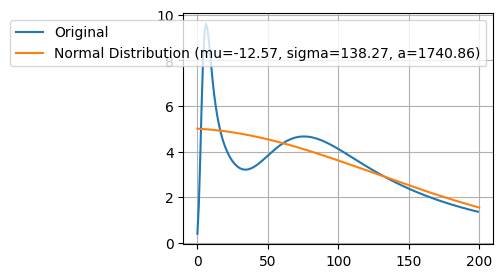

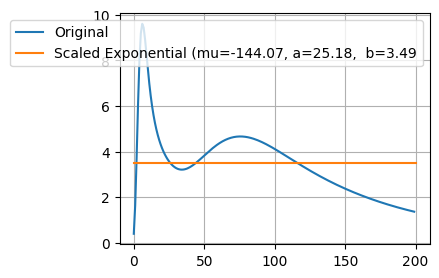

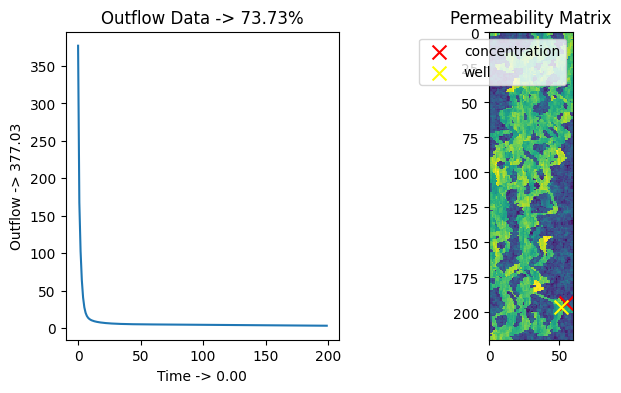

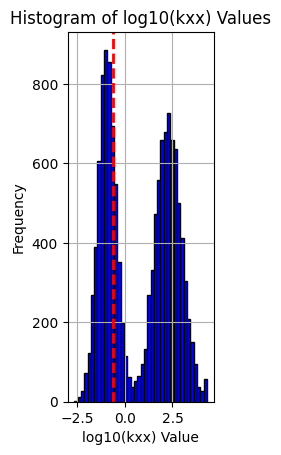

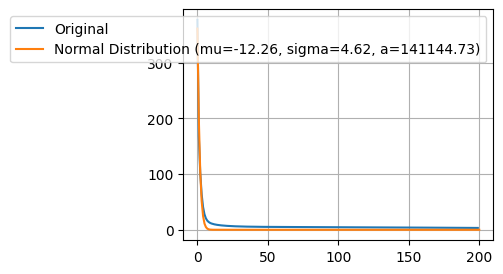

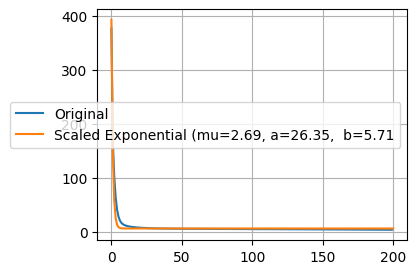

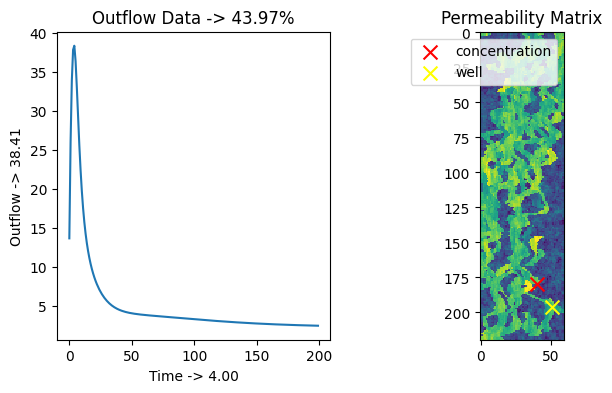

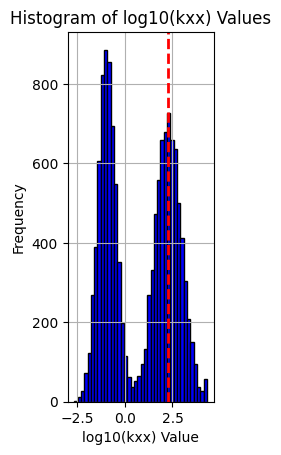

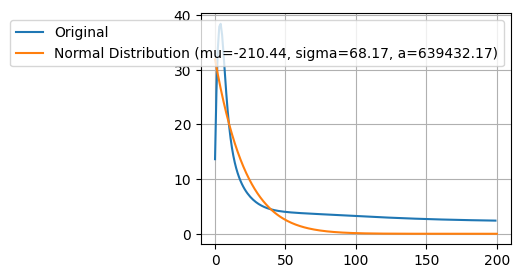

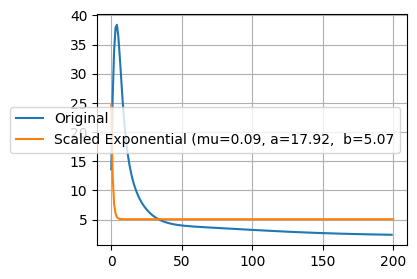

In [83]:
# plot exponential cases
list_initial_conc_pos = []
for elem in list_of_exponentials_inputs:
    initial_conc_pos = [elem[0]*6.096, elem[1]*3.048]
    list_initial_conc_pos.append(initial_conc_pos)

for elem in list_initial_conc_pos:
    out = compute_outflow(elem, sd, perm_dict, q, b_faces, vect, M, U, b_upwind, pos_well, plots=True)
    estimate_gaussian_parameters(out, plots=True)
    estimate_exponential_parameters(out, plots=True)

Epoch 1/200:   0%|          | 0/1837 [00:00<?, ?it/s]

Epoch 200/200: 100%|██████████| 1837/1837 [00:01<00:00, 1354.98it/s, Loss=0.0113]


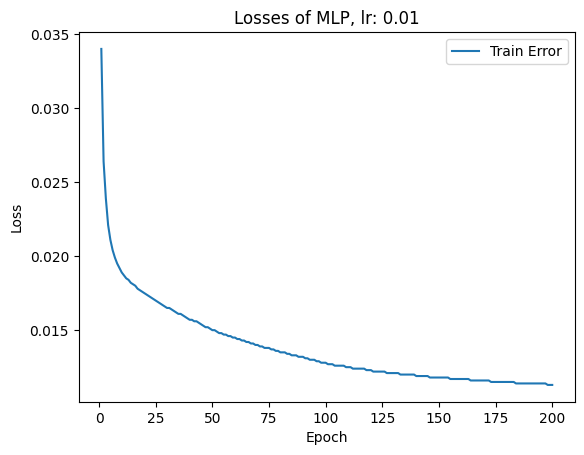

In [14]:
mlp = MLP()
optimizer = optim.SGD(mlp.parameters(), lr=0.005)
criterion = nn.MSELoss(reduce=None, reduction='mean')
num_epochs = 200

losses, validation_losses = [], []
best_loss = best_val_error = float('inf')
best_model_state = None
patience, counter = 5, 0

for epoch in range(num_epochs):

    count_loss = count_loss_val = 0
    
    with tqdm(total=len(inputs_tensor), desc=f"Epoch {epoch + 1}/{num_epochs}", file=sys.stdout, colour="green") as pbar:    
        
        mlp.train()
            
        for Input, target in zip(inputs_tensor, targets_tensor):
            optimizer.zero_grad()
            output = mlp.forward(Input)
            loss = criterion(output, target)
            count_loss += loss.item()
            loss.backward()
            optimizer.step()
            pbar.update(1)
            
        # with torch.no_grad():
        #     mlp51.eval()
        #     for input_val, target_val in zip(inputs_val_IT1, targets_val):
        #         output = mlp51.forward(input_val)
        #         loss = criterion(output, target_val)
        #         count_loss_val += loss.item()    
                
        avg_loss = np.round(count_loss/len(inputs_tensor), 4)
        # avg_loss_val = np.round(count_loss_val/len(inputs_val_IT1), 4)
        losses.append(avg_loss)
        # validation_losses.append(avg_loss_val)
        
        pbar.set_postfix({'Loss': avg_loss})
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}")
        # print(f"Epoch {epoch + 1}/{num_epochs}, Validation Error: {avg_loss_val}")
    
        # if avg_loss_val < best_val_error:
        #     best_val_error = avg_loss_val
        #     loss_at_best_val = avg_loss
        #     best_model_state = mlp51.state_dict()
        #     best_epoch_idx = epoch
        #     best_model_path = f'PoreWorld/models/MLP_{layer}.pth'
        
        if np.round(count_loss, 3) < np.round(best_loss, 3):
            best_loss = count_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"No improvement for {patience} epochs. Stopping training.")
                print()
                break

best_model_path = f'PoreWorld/models/MLP_{layer}_Norm.pth'
torch.save(mlp.state_dict(), best_model_path)
plt.plot(range(1, len(losses[:]) + 1), losses[:], label='Train Error')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Losses of MLP, lr: 0.01')
plt.legend()
plt.show()

Epoch 100/100: 100%|██████████| 67/67 [00:00<00:00, 1356.70it/s, Loss=0.0024]


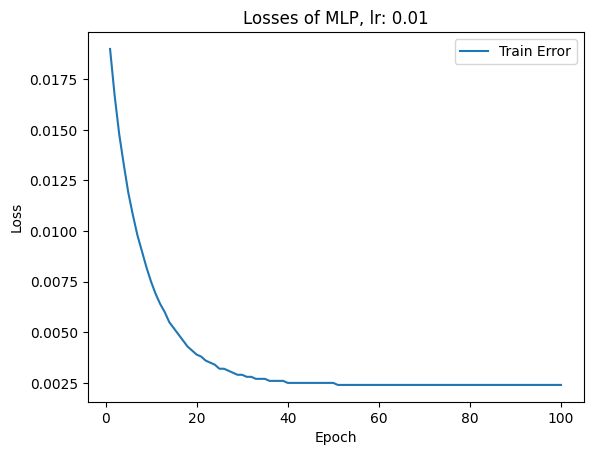

In [15]:
mlp = MLP()
optimizer = optim.SGD(mlp.parameters(), lr=0.001)
criterion = nn.MSELoss(reduce=None, reduction='mean')
num_epochs = 100

losses, validation_losses = [], []
best_loss = best_val_error = float('inf')
best_model_state = None
patience, counter = 5, 0

for epoch in range(num_epochs):

    count_loss = count_loss_val = 0
    
    with tqdm(total=len(inputs_tensor_exponentials), desc=f"Epoch {epoch + 1}/{num_epochs}", file=sys.stdout, colour="green") as pbar:    
        
        mlp.train()
            
        for Input, target in zip(inputs_tensor_exponentials, targets_tensor_exponentials):
            optimizer.zero_grad()
            output = mlp.forward(Input)
            loss = criterion(output, target)
            count_loss += loss.item()
            loss.backward()
            optimizer.step()
            pbar.update(1)
            
        # with torch.no_grad():
        #     mlp51.eval()
        #     for input_val, target_val in zip(inputs_val_IT1, targets_val):
        #         output = mlp51.forward(input_val)
        #         loss = criterion(output, target_val)
        #         count_loss_val += loss.item()    
                
        avg_loss = np.round(count_loss/len(inputs_tensor), 4)
        # avg_loss_val = np.round(count_loss_val/len(inputs_val_IT1), 4)
        losses.append(avg_loss)
        # validation_losses.append(avg_loss_val)
        
        pbar.set_postfix({'Loss': avg_loss})
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}")
        # print(f"Epoch {epoch + 1}/{num_epochs}, Validation Error: {avg_loss_val}")
    
        # if avg_loss_val < best_val_error:
        #     best_val_error = avg_loss_val
        #     loss_at_best_val = avg_loss
        #     best_model_state = mlp51.state_dict()
        #     best_epoch_idx = epoch
        #     best_model_path = f'PoreWorld/models/MLP_{layer}.pth'
        
        if np.round(count_loss, 3) < np.round(best_loss, 3):
            best_loss = count_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"No improvement for {patience} epochs. Stopping training.")
                print()
                break

best_model_path = f'PoreWorld/models/MLP_{layer}_Exp.pth'
torch.save(mlp.state_dict(), best_model_path)
plt.plot(range(1, len(losses[:]) + 1), losses[:], label='Train Error')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Losses of MLP, lr: 0.01')
plt.legend()
plt.show()

## Prediction

In [23]:
def normal_distribution(x, mu, sigma, a):
        return a*norm.pdf(x, mu, sigma)
        
def scaled_exponential(x, mu, a, b):
        return a * np.exp(-(x - mu)) + b

In [24]:
def Checkpoint3_solution(selected_layer, initial_conc_pos, L=50):
    
    layer = selected_layer
    spe10 = Spe10(layer)
    sd = spe10.sd
    perm_folder = spe10_folder + "/perm/"
    spe10.read_perm(perm_folder)
    perm_dict = spe10.perm_as_dict()
    kxx = perm_dict["kxx"]

    with open(f'PoreWorld/data/l{selected_layer}.pickle', 'rb') as f: data = pickle.load(f)
    pos_well = data[1][np.argmin(data[2])]
    print(f"Initial conc position: {initial_conc_pos}")
    print(f"Position of well: {pos_well}")

    ###
    width, height = 10, 35
    a, b = height/2, width/2
    if  (((initial_conc_pos[0] - pos_well[0]/6.096)**2)*(a**2) + (initial_conc_pos[1] - pos_well[1]/3.048)**2)*(b**2) <= (a**2 * b**2):
        loadname = "Exp"
    else:
        loadname = "Norm"
    ###

    _, _, q, b_faces, vect, M, U, b_upwind = solve_darcy(layer, pos_well)

    Input, _ = generate_neural_network_training_data(sd, kxx, perm_dict, q, b_faces, vect, M, U, b_upwind, initial_conc_pos, pos_well)
    input_tensor = torch.tensor(Input)
    input_tensor = input_tensor.reshape(1, -1)
    print(f"Input tensor: {input_tensor}")

    with open(f'PoreWorld/models/layer_{layer}_{loadname}_scaler_inputs.pickle', 'rb') as f: scaler_inputs = pickle.load(f)
    with open(f'PoreWorld/models/layer_{layer}_{loadname}_scaler_targets.pickle', 'rb') as f: scaler_targets = pickle.load(f)
    scaled_input = torch.tensor(scaler_inputs.transform(input_tensor))
    input_tensor = scaled_input.float()
    print(f"Scaled input tensor: {input_tensor}")

    mlp = MLP()
    best_model_path = f'PoreWorld/models/MLP_{layer}_{loadname}.pth'
    mlp.load_state_dict(torch.load(best_model_path))
    mlp.eval()

    with torch.no_grad():
        prediction = mlp(input_tensor)
        print(f"Prediction: {prediction}")
        transformed_prediction = scaler_targets.inverse_transform(prediction)
        print(f"Transformed prediction: {transformed_prediction}")

    prediction_tensor = torch.tensor(transformed_prediction)
    norm_prediction = torch.norm(prediction_tensor)
    print(f"Norm of prediction: {norm_prediction}")

    if loadname == "Norm":
        print("Norm!!")
        x = np.linspace(0, 200, 200)
        if norm_prediction >= 500:
            print(norm_prediction)
            outflow = normal_distribution(x, transformed_prediction[0][0], transformed_prediction[0][1], transformed_prediction[0][2])
        elif 200 < norm_prediction < 500:
            outflow = np.zeros((200,))

    elif loadname == "Exp":
        print("Exp!!")
        x = np.linspace(0, 200, 200)
        outflow = scaled_exponential(x, transformed_prediction[0][0], transformed_prediction[0][1], transformed_prediction[0][2])

    return outflow

Initial conc position: [350, 550]
Position of well: [313.9440000000001, 598.9319999999999]


Input tensor: tensor([[5.7000e+01, 1.8000e+02, 2.0138e-01, 1.6314e+01, 6.3014e-02, 3.9842e-02]],
       dtype=torch.float64)
Scaled input tensor: tensor([[9.6610e-01, 8.2488e-01, 9.8127e-06, 8.1552e-04, 2.9761e-06, 1.8500e-06]])
Prediction: tensor([[0.1804, 0.0915, 0.3687]])
Transformed prediction: [[  43.88146848   16.15186655 1083.54666633]]
Norm of prediction: 1084.5551365343306
Norm!!
tensor(1084.5551, dtype=torch.float64)


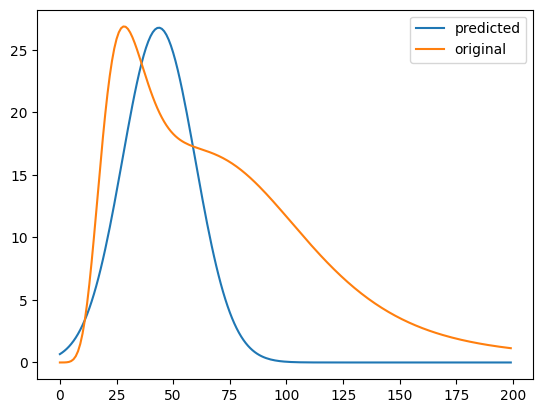

In [25]:
# list_initial_conc_pos = [(319.5400000000001, 414.1)] # flat line, integral = 0
# list_initial_conc_pos = [[48,600]]    # "standard" Normal
# list_initial_conc_pos = [[48,600], [292,495], [350,450], [50,25]] # prof's starting points
# list_initial_conc_pos = [(246.38800000000003, 548.212)]                                   # max time 4.0 sec -> N NOT OK, EXP NEITHER, mu < 0, a huge
# list_initial_conc_pos = [[np.floor(55.0*6.096), np.floor(49.0*3.0479999999999996)]]
# list_initial_conc_pos = [[300,550]]                                                     # max time 178.0 sec -> patologico ma N OK
list_initial_conc_pos = [[350,550]]                                                     # max time 199.0 sec -> patologico ma N OK, 3 params range accettabile
# list_initial_conc_pos = [[np.floor(40.0*6.096), np.floor(179.0*3.0479999999999996)]]    # max time 4.0 sec -> patologico, a huge
# list_initial_conc_pos = [[np.floor(40.0*6.096), np.floor(169.0*3.0479999999999996)]]    # double spike -> patological
# list_initial_conc_pos = [[300,600]]                                                     # exponential, time 0.0 sec -> patological, mu < 0 and a huge
# list_initial_conc_pos = [(326, 638.212)] # outflow 100%, N OK but a huge
# list_initial_conc_pos = [(316, 638.212)] # outflow 100%, N OK but mu < 0, a huge
# list_initial_conc_pos = [(313, 560.212)]
# list_initial_conc_pos = [(319, 579.212)]        # very close to well

for elem in list_initial_conc_pos:
    outflow = Checkpoint3_solution(51, elem)

# sd, perm_dict, q, b_faces, vect, M, U, b_upwind = solve_darcy(51, pos_well)
for elem in list_initial_conc_pos:
    out = compute_outflow(elem, sd, perm_dict, q, b_faces, vect, M, U, b_upwind, pos_well, plots=False)

plt.plot(outflow, label='predicted')
plt.plot(out, label='original')
plt.legend()

## Checkpoint

In [94]:
selected_layers = [51, 71, 42, 20, 12, 2, 82]

if __name__ == '__main__':

    for i in range(7):
    
        outflow = Checkpoint3_solution(selected_layers[i], [120, 250])